In [1]:
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline
from transformers import BertTokenizer, BertModel
import matplotlib.pyplot as plt
import spacy
import torch.nn as nn
import torch.optim as optim
from torch.hub import load
from gensim.models import Word2Vec
from sklearn.neighbors import KNeighborsRegressor





In [2]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Load dataset
file_path = 'full_format_recipes.json' 
data = pd.read_json(file_path)
data.dropna(inplace=True)
data = data.sample(frac=1, random_state=42).reset_index(drop=True)



In [4]:

# Basic exploration
print(f"Dataset shape: {data.shape}")
print("Columns:", data.columns)

Dataset shape: (10608, 11)
Columns: Index(['directions', 'fat', 'date', 'categories', 'calories', 'desc',
       'protein', 'rating', 'title', 'ingredients', 'sodium'],
      dtype='object')


In [5]:
# Focus on relevant columns
StringData = data[['directions', 'desc', 'rating','categories','title']].copy()

StringDataWithNames=data[['directions', 'desc', 'rating','categories','title']].copy()






In [6]:
# Handle nested structures and add column names before each value
string_columns = ['directions', 'categories', 'desc', 'title']

for col in string_columns:
    StringDataWithNames[col] = StringDataWithNames[col].apply(
        lambda x: f"{col}: {', '.join(map(str, x))}" if isinstance(x, (list, np.ndarray)) else f"{col}: {x}" if pd.notnull(x) else x
    )

# Ensure all values are strings before concatenation
StringDataWithNames['Alltext'] = StringDataWithNames['directions'].apply(
    lambda x: " ".join(x) if isinstance(x, list) else str(x)
) + " " + StringDataWithNames['categories'].apply(
    lambda x: " ".join(x) if isinstance(x, list) else str(x)
) + " " + StringDataWithNames['desc'].apply(
    lambda x: str(x)
) + " " + StringDataWithNames['title'].apply(
    lambda x: str(x)
)




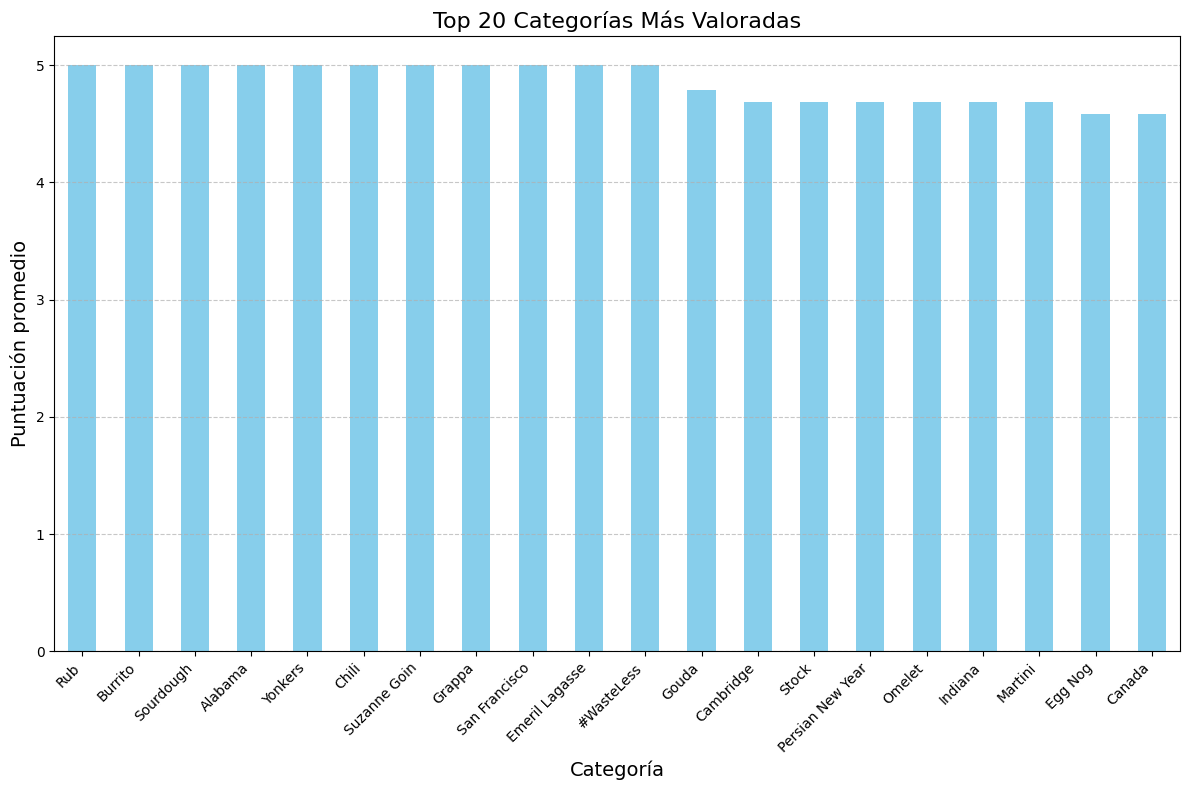

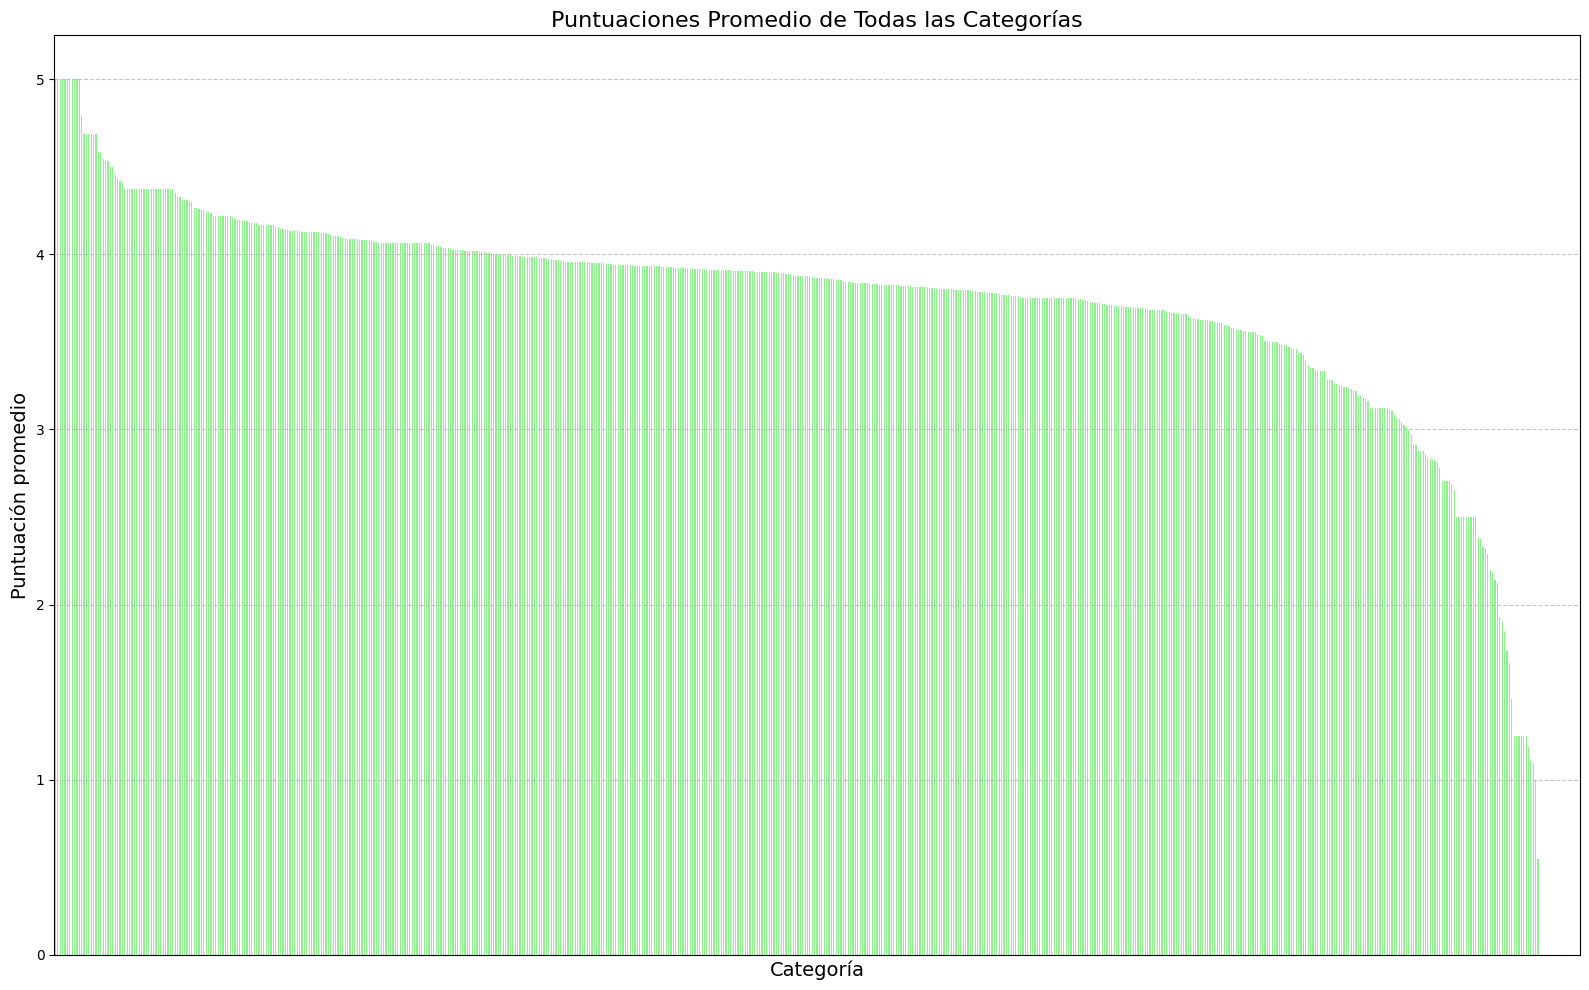

Número total de categorías únicas: 637


In [7]:


# Explode the 'categories' column and calculate mean ratings for each category
categories_exploded = data.explode('categories')
category_ratings = categories_exploded.groupby('categories')['rating'].mean().sort_values(ascending=False)

# Plot the top 20 categories
plt.figure(figsize=(12, 8))
category_ratings.head(20).plot(kind='bar', color='skyblue')
plt.title('Top 20 Categorías Más Valoradas', fontsize=16)
plt.xlabel('Categoría', fontsize=14)
plt.ylabel('Puntuación promedio', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plot all categories without x-axis labels
plt.figure(figsize=(16, 10))
category_ratings.plot(kind='bar', color='lightgreen')
plt.title('Puntuaciones Promedio de Todas las Categorías', fontsize=16)
plt.xlabel('Categoría', fontsize=14)
plt.ylabel('Puntuación promedio', fontsize=14)
plt.xticks([])  # Removes x-axis labels
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Display the total number of unique categories
categorias_unicas = categories_exploded['categories'].nunique()
print(f"Número total de categorías únicas: {categorias_unicas}")




In [8]:
# Text preprocessing function
nlp = spacy.load('en_core_web_sm')
def preprocess_text(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc if not token.is_stop and token.is_alpha])


In [9]:


# Apply preprocessing
StringData['processed_directions'] = StringData['directions'].apply(lambda x: preprocess_text(" ".join(x) if isinstance(x, list) else x))
StringData['processed_desc'] = StringData['desc'].apply(lambda x: preprocess_text(" ".join(x) if isinstance(x, list) else x))
StringData['processed_categories'] = StringData['categories'].apply(lambda x: preprocess_text(" ".join(x) if isinstance(x, list) else x))
StringData['processed_title'] = StringData['title'].apply(lambda x: preprocess_text(" ".join(x) if isinstance(x, list) else x))







In [10]:
# Extract and normalize numeric features
numeric_features = data[['fat', 'protein', 'calories', 'sodium']]
scaler = StandardScaler()
numeric_features = scaler.fit_transform(numeric_features)

In [11]:
print(StringData[['processed_directions', 'processed_desc', 'processed_categories', 'processed_title']].head())

                                processed_directions  \
0  simmer pea cream red pepper flake garlic teasp...   
1  Combine sugar orange juice concentrate water h...   
2  preheat oven F Butter flour cup Bundt pan Whis...   
3  heat peanut oil heavy large pot medium high he...   
4  stir ingredient small bowl blend season taste ...   

                                      processed_desc  \
0  zing fresh lemon enhance pea sweetness natural...   
1           Orange syrup sweeten cake fresh fruit go   
2  brandied whip cream add perfect finishing touc...   
3  hearty stew like soup inspire vietnamese pho h...   
4                                 nice toasted bagel   

                                processed_categories  \
0  Milk Cream Pasta Christmas Vegetarian Quick Ea...   
1  chocolate Dessert Bake Passover Orange Date Wa...   
2  Cake Fruit Dessert Currant Orange Pineapple Al...   
3  Soup Stew Beef Sauté Dinner Lunch Spring Noodl...   
4  Condiment Spread Dairy fish Herb Breakfast 

--------------------------------------------------------------------TF-IDF------------------------------------------------------------------

In [12]:
# TF-IDF vectorization for individual columns
vectorizer = TfidfVectorizer(max_features=100)
categories_tfidf = vectorizer.fit_transform(StringData['processed_categories'])
desc_tfidf = vectorizer.fit_transform(StringData['processed_desc'])
directions_tfidf = vectorizer.fit_transform(StringData['processed_directions'])
title_tfidf = vectorizer.fit_transform(StringData['processed_title'])

In [13]:
#Convert data to X and Y combining numeric and written features
X_TFIDF = torch.tensor(
    pd.concat(
        [pd.DataFrame(categories_tfidf.toarray()), pd.DataFrame(desc_tfidf.toarray()), pd.DataFrame(directions_tfidf.toarray()), pd.DataFrame(title_tfidf.toarray()), pd.DataFrame(numeric_features)],
        axis=1
    ).values,
    dtype=torch.float32
)
y = torch.tensor(data['rating'].values, dtype=torch.float32)  # Target variable

In [14]:
# Train-test-validation split
X_train_TFIDF, X_test_TFIDF, y_train, y_test = train_test_split(
   X_TFIDF, y, test_size=0.2, random_state=42)

X_val_TFIDF, X_test_TFIDF, y_val, y_test = train_test_split(
    X_test_TFIDF, y_test, test_size=0.5, random_state=42)  

--------------------------------------------------------------------WORD2VEC------------------------------------------------------------------

In [15]:
# Prepare data for Word2Vec
documents = StringData['processed_directions'].tolist() + StringData['processed_desc'].tolist() + \
            StringData['processed_categories'].tolist() + StringData['processed_title'].tolist()
tokenized_documents = [doc.split() for doc in documents]



In [16]:
# Train Word2Vec model
word2vec_model = Word2Vec(sentences=tokenized_documents, vector_size=100, window=5, min_count=1, workers=4)

In [17]:
# Function to calculate document embeddings
def get_doc_embedding(doc, model):
    words = doc.split()
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    if len(word_vectors) > 0:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(model.vector_size)


In [18]:

# Generate Word2Vec embeddings for each column
StringData['directions_w2v'] = StringData['processed_directions'].apply(lambda x: get_doc_embedding(x, word2vec_model))
StringData['desc_w2v'] = StringData['processed_desc'].apply(lambda x: get_doc_embedding(x, word2vec_model))
StringData['categories_w2v'] = StringData['processed_categories'].apply(lambda x: get_doc_embedding(x, word2vec_model))
StringData['title_w2v'] = StringData['processed_title'].apply(lambda x: get_doc_embedding(x, word2vec_model))


In [19]:

# Combine Word2Vec embeddings into a single feature matrix
w2v_features = np.array(StringData['directions_w2v'].tolist()) + \
               np.array(StringData['desc_w2v'].tolist()) + \
               np.array(StringData['categories_w2v'].tolist()) + \
               np.array(StringData['title_w2v'].tolist())


In [20]:
#Convert data to X and Y combining numeric and written features
X_W2V = torch.tensor(
    pd.concat(
        [pd.DataFrame(w2v_features), pd.DataFrame(numeric_features)],
        axis=1
    ).values,
    dtype=torch.float32
)
y = torch.tensor(data['rating'].values, dtype=torch.float32)  # Target variable

#
# final_features = np.hstack([w2v_features, numeric_features])


In [21]:
# Train-test split
X_train_W2V, X_test_W2V, y_train, y_test = train_test_split(
   X_W2V, y, test_size=0.2, random_state=42)
X_val_W2V, X_test_W2V, y_val, y_test = train_test_split(
    X_test_W2V, y_test, test_size=0.5, random_state=42)  

--------------------------------------------------------------------BERT------------------------------------------------------------------

In [22]:

# Using BERT embeddings for contextual embeddings
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')


In [23]:
def get_bert_embeddings(text_list):
    tokens = tokenizer(text_list, padding=True, truncation=True, max_length=32, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**tokens)
    # Use the CLS token embeddings as the document representation
    return outputs.last_hidden_state[:, 0, :].numpy()



In [24]:
#X_text_Prebert = StringDataWithNames['Alltext']
#X_embeddings = get_bert_embeddings(X_text_Prebert.tolist())
embeddings_directions = get_bert_embeddings(StringDataWithNames['directions'].tolist())
embeddings_desc = get_bert_embeddings(StringDataWithNames['desc'].tolist())
embeddings_categories = get_bert_embeddings(StringDataWithNames['categories'].tolist())
embeddings_title = get_bert_embeddings(StringDataWithNames['title'].tolist())

# Stack all features together
X_embeddings = np.hstack([
    embeddings_directions,
    embeddings_desc,
    embeddings_categories,
    embeddings_title,
    numeric_features
])





In [25]:
# Combine BERT embeddings and numeric features
X_BERT = torch.tensor(
    pd.concat(
        [pd.DataFrame(X_embeddings), pd.DataFrame(numeric_features)],
        axis=1
    ).values,
    dtype=torch.float32
)
y = torch.tensor(data['rating'].values, dtype=torch.float32)  # Target variable

In [26]:
# Split BERT
X_train_bert, X_test_bert, y_train, y_test = train_test_split(
    X_BERT, y, test_size=0.2, random_state=42)

X_val_bert, X_test_bert, y_val, y_test = train_test_split(
    X_test_bert, y_test, test_size=0.5, random_state=42)

-----------------------------------------------------------------------------Before Starting---------------------------------------------------------------------

In [27]:

# Calculate the mean of the 'rating' feature
mean_rating = StringData['rating'].mean()

# Create a prediction array with the mean value for all samples
predictions = np.full_like(StringData['rating'], mean_rating)

# Calculate the MAE
mae = mean_absolute_error(StringData['rating'], predictions)

print(f"Mean rating: {mean_rating}")
print(f"MAE when predicting the mean: {mae}")

Mean rating: 3.8045578808446456
MAE when predicting the mean: 0.828418629242508


--------------------------------------------------------------------KNN------------------------------------------------------------------

In [28]:

knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train_TFIDF, y_train)

KNeighborsRegressor()

In [29]:
# Ensure X_test and y_test are numpy arrays
#X_test_bert_np = X_train_bert.cpu().numpy() if isinstance(X_train_bert, torch.Tensor) else X_train_bert
#y_test_np = y_test.cpu().numpy() if isinstance(y_test, torch.Tensor) else y_test

# Predictions and evaluation
knn_predictions = knn_model.predict(X_test_TFIDF)
print("KNN MSE:", mean_squared_error(y_test, knn_predictions))
print("KNN MAE:", mean_absolute_error(y_test, knn_predictions))

KNN MSE: 1.562175989151001
KNN MAE: 0.8282281160354614


In [30]:
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train_W2V, y_train)

KNeighborsRegressor()

In [31]:
# Ensure X_test and y_test are numpy arrays
#X_test_W2V_np = X_test_W2V.cpu().numpy() if isinstance(X_test_W2V, torch.Tensor) else X_test_W2V
#y_test_np = y_test.cpu().numpy() if isinstance(y_test, torch.Tensor) else y_test


# Ensure y_test is a NumPy array
y_test_np = np.array(y_test)

# Compute metrics


# Predictions and evaluation
knn_predictions = knn_model.predict(X_test_W2V)
print("KNN MSE:", mean_squared_error(y_test, knn_predictions))
print("KNN MAE:",  mean_absolute_error(y_test, knn_predictions))


KNN MSE: 1.4980560541152954
KNN MAE: 0.8197455406188965


In [32]:
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train_bert, y_train)


KNeighborsRegressor()

In [33]:

# Ensure X_test and y_test are numpy arrays
#X_test_W2V_np = X_test_W2V.cpu().numpy() if isinstance(X_test_W2V, torch.Tensor) else X_test_W2V
#y_test_np = y_test.cpu().numpy() if isinstance(y_test, torch.Tensor) else y_test


# Ensure y_test is a NumPy array
y_test_np = np.array(y_test)

# Compute metrics


# Predictions and evaluation
knn_predictions = knn_model.predict(X_test_bert)
print("KNN MSE:", mean_squared_error(y_test_np, knn_predictions))
print("KNN MAE:",  mean_absolute_error(y_test,knn_predictions))


KNN MSE: 1.5244168043136597
KNN MAE: 0.815504252910614


--------------------------------------------------------------------SIMPLE NN------------------------------------------------------------------

----------------------------------------------------------------------SIMPLE NN WITH W2V-----------------------------------------------------------

In [34]:
# Train a neural network using PyTorch
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.fc(x)



In [35]:
input_size = X_train_W2V.shape[1]
model = SimpleNN(input_size).to(device)

criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [36]:
# Convert data to tensors
# Ensure tensors are created correctly without redundant wrapping
X_train_tensor = torch.from_numpy(X_train_W2V).float().to(device) if isinstance(X_train_W2V, np.ndarray) else X_train_W2V.clone().detach().float().to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device) if not torch.is_tensor(y_train) else y_train.clone().detach().view(-1, 1).to(device)

X_val_tensor = torch.from_numpy(X_val_W2V).float().to(device) if isinstance(X_val_W2V, np.ndarray) else X_val_W2V.clone().detach().float().to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1).to(device) if not torch.is_tensor(y_val) else y_val.clone().detach().view(-1, 1).to(device)

X_test_tensor = torch.from_numpy(X_test_W2V).float().to(device) if isinstance(X_test_W2V, np.ndarray) else X_test_W2V.clone().detach().float().to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device) if not torch.is_tensor(y_test) else y_test.clone().detach().view(-1, 1).to(device)


In [37]:
# Training loop
best_val_loss = float('inf')  # Initialize to a large value
patience = 200  # Number of epochs to wait before stopping
tolerance = 1e-6  # Minimum improvement in validation loss to consider it better
no_improve_epochs = 0  # Counter for early stopping

# Save the best model
best_model_state = None

for epoch in range(1000):
    # Training phase
    model.train()
    optimizer.zero_grad()
    predictions = model(X_train_tensor)
    train_loss = criterion(predictions, y_train_tensor)
    train_loss.backward()
    optimizer.step()

    # Validation phase
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_val_tensor)
        val_loss = criterion(val_predictions, y_val_tensor)

    # Check for early stopping
    if val_loss.item() < best_val_loss - tolerance:
        best_val_loss = val_loss.item()
        best_model_state = model.state_dict()  # Save the best model
        no_improve_epochs = 0  # Reset counter
    else:
        no_improve_epochs += 1

    # Logging
    if (epoch + 1) % 10 == 0 or no_improve_epochs == 0:
        print(f"Epoch {epoch+1}, Training Loss: {train_loss.item()}, Validation Loss: {val_loss.item()}")

    # Early stopping condition
    if no_improve_epochs >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

# Restore the best model after early stopping
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"Model restored to the state from epoch with Validation Loss: {best_val_loss}")



Epoch 1, Training Loss: 3.8174850940704346, Validation Loss: 3.6464450359344482
Epoch 2, Training Loss: 3.6089365482330322, Validation Loss: 3.440606117248535
Epoch 3, Training Loss: 3.411381959915161, Validation Loss: 3.2363953590393066
Epoch 4, Training Loss: 3.216061592102051, Validation Loss: 3.0315780639648438
Epoch 5, Training Loss: 3.0203397274017334, Validation Loss: 2.825301170349121
Epoch 6, Training Loss: 2.823639154434204, Validation Loss: 2.6171813011169434
Epoch 7, Training Loss: 2.625042676925659, Validation Loss: 2.406358242034912
Epoch 8, Training Loss: 2.423401355743408, Validation Loss: 2.193600654602051
Epoch 9, Training Loss: 2.218214988708496, Validation Loss: 1.9782450199127197
Epoch 10, Training Loss: 2.0090172290802, Validation Loss: 1.765012264251709
Epoch 11, Training Loss: 1.7984422445297241, Validation Loss: 1.5615345239639282
Epoch 12, Training Loss: 1.5933810472488403, Validation Loss: 1.372430443763733
Epoch 13, Training Loss: 1.406861424446106, Validati

In [38]:
# Evaluation

# Ensure the model is in evaluation mode
model.eval()

# Perform evaluation
with torch.no_grad():
    # Get predictions from the model
    test_predictions = model(X_test_tensor)
    
    # Calculate loss (optional, if criterion is defined)
    test_loss = criterion(test_predictions, y_test_tensor)
    print("Neural Network Test Loss:", test_loss.item())
    
    # Convert predictions and ground truth to NumPy for compatibility with metrics
    test_predictions_np = test_predictions.cpu().numpy()
    y_test_np = y_test_tensor.cpu().numpy()
    
    print("Neural Network Test Metrics:")
    print(f" - Mean Squared Error (MSE): { mean_squared_error(y_test_np, test_predictions_np)}")
    print(f" - Mean Absolute Error (MAE): {mean_absolute_error(y_test_np, test_predictions_np)}")



Neural Network Test Loss: 0.7679861783981323
Neural Network Test Metrics:
 - Mean Squared Error (MSE): 1.5356605052947998
 - Mean Absolute Error (MAE): 0.7679862380027771


----------------------------------------------------------------------SIMPLE NN WITH TFIDF-----------------------------------------------------------

In [39]:
input_size = X_train_TFIDF.shape[1]
model = SimpleNN(input_size).to(device)

criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [40]:
# Convert data to tensors
# Ensure tensors are created correctly without redundant wrapping
X_train_tensor = torch.from_numpy(X_train_TFIDF).float().to(device) if isinstance(X_train_TFIDF, np.ndarray) else X_train_TFIDF.clone().detach().float().to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device) if not torch.is_tensor(y_train) else y_train.clone().detach().view(-1, 1).to(device)

X_val_tensor = torch.from_numpy(X_val_TFIDF).float().to(device) if isinstance(X_val_TFIDF, np.ndarray) else X_val_TFIDF.clone().detach().float().to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1).to(device) if not torch.is_tensor(y_val) else y_val.clone().detach().view(-1, 1).to(device)

X_test_tensor = torch.from_numpy(X_test_TFIDF).float().to(device) if isinstance(X_test_TFIDF, np.ndarray) else X_test_TFIDF.clone().detach().float().to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device) if not torch.is_tensor(y_test) else y_test.clone().detach().view(-1, 1).to(device)


In [41]:
# Training loop
best_val_loss = float('inf')  # Initialize to a large value
patience = 200  # Number of epochs to wait before stopping
tolerance = 1e-6  # Minimum improvement in validation loss to consider it better
no_improve_epochs = 0  # Counter for early stopping

# Save the best model
best_model_state = None

for epoch in range(1000):
    # Training phase
    model.train()
    optimizer.zero_grad()
    predictions = model(X_train_tensor)
    train_loss = criterion(predictions, y_train_tensor)
    train_loss.backward()
    optimizer.step()

    # Validation phase
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_val_tensor)
        val_loss = criterion(val_predictions, y_val_tensor)

    # Check for early stopping
    if val_loss.item() < best_val_loss - tolerance:
        best_val_loss = val_loss.item()
        best_model_state = model.state_dict()  # Save the best model
        no_improve_epochs = 0  # Reset counter
    else:
        no_improve_epochs += 1

    # Logging
    if (epoch + 1) % 10 == 0 or no_improve_epochs == 0:
        print(f"Epoch {epoch+1}, Training Loss: {train_loss.item()}, Validation Loss: {val_loss.item()}")

    # Early stopping condition
    if no_improve_epochs >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

# Restore the best model after early stopping
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"Model restored to the state from epoch with Validation Loss: {best_val_loss}")

Epoch 1, Training Loss: 3.7528672218322754, Validation Loss: 3.7676191329956055
Epoch 2, Training Loss: 3.7214345932006836, Validation Loss: 3.7341554164886475
Epoch 3, Training Loss: 3.6890792846679688, Validation Loss: 3.699528455734253
Epoch 4, Training Loss: 3.6555347442626953, Validation Loss: 3.66337513923645
Epoch 5, Training Loss: 3.6205155849456787, Validation Loss: 3.625406265258789
Epoch 6, Training Loss: 3.583751678466797, Validation Loss: 3.5853865146636963
Epoch 7, Training Loss: 3.545194149017334, Validation Loss: 3.5431060791015625
Epoch 8, Training Loss: 3.5044333934783936, Validation Loss: 3.498453140258789
Epoch 9, Training Loss: 3.4613046646118164, Validation Loss: 3.451314687728882
Epoch 10, Training Loss: 3.4157462120056152, Validation Loss: 3.401690721511841
Epoch 11, Training Loss: 3.367748260498047, Validation Loss: 3.3495657444000244
Epoch 12, Training Loss: 3.3173117637634277, Validation Loss: 3.294950485229492
Epoch 13, Training Loss: 3.2644460201263428, Val

In [42]:
# Evaluation

# Ensure the model is in evaluation mode
model.eval()

# Perform evaluation
with torch.no_grad():
    # Get predictions from the model
    test_predictions = model(X_test_tensor)
    
    # Calculate loss (optional, if criterion is defined)
    test_loss = criterion(test_predictions, y_test_tensor)
    print("Neural Network Test Loss:", test_loss.item())
    
    # Convert predictions and ground truth to NumPy for compatibility with metrics
    test_predictions_np = test_predictions.cpu().numpy()
    y_test_np = y_test_tensor.cpu().numpy()
    
    print("Neural Network Test Metrics:")
    print(f" - Mean Squared Error (MSE): { mean_squared_error(y_test_np, test_predictions_np)}")
    print(f" - Mean Absolute Error (MAE): {mean_absolute_error(y_test_np, test_predictions_np)}")

Neural Network Test Loss: 0.7704415321350098
Neural Network Test Metrics:
 - Mean Squared Error (MSE): 1.449597954750061
 - Mean Absolute Error (MAE): 0.7704415321350098


----------------------------------------------------------------------SIMPLE NN WITH BERT-----------------------------------------------------------

In [43]:
input_size = X_train_bert.shape[1]
model = SimpleNN(input_size).to(device)

criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [44]:
# Convert data to tensors
# Ensure tensors are created correctly without redundant wrapping
X_train_tensor = torch.from_numpy(X_train_bert).float().to(device) if isinstance(X_train_bert, np.ndarray) else X_train_bert.clone().detach().float().to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device) if not torch.is_tensor(y_train) else y_train.clone().detach().view(-1, 1).to(device)

X_val_tensor = torch.from_numpy(X_val_bert).float().to(device) if isinstance(X_val_bert, np.ndarray) else X_val_bert.clone().detach().float().to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1).to(device) if not torch.is_tensor(y_val) else y_val.clone().detach().view(-1, 1).to(device)

X_test_tensor = torch.from_numpy(X_test_bert).float().to(device) if isinstance(X_test_bert, np.ndarray) else X_test_bert.clone().detach().float().to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device) if not torch.is_tensor(y_test) else y_test.clone().detach().view(-1, 1).to(device)


In [45]:
# Training loop
best_val_loss = float('inf')  # Initialize to a large value
patience = 500  # Number of epochs to wait before stopping
tolerance = 1e-5  # Minimum improvement in validation loss to consider it better
no_improve_epochs = 0  # Counter for early stopping

# Save the best model
best_model_state = None

for epoch in range(1000):
    # Training phase
    model.train()
    optimizer.zero_grad()
    predictions = model(X_train_tensor)
    train_loss = criterion(predictions, y_train_tensor)
    train_loss.backward()
    optimizer.step()

    # Validation phase
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_val_tensor)
        val_loss = criterion(val_predictions, y_val_tensor)

    # Check for early stopping
    if val_loss.item() < best_val_loss - tolerance:
        best_val_loss = val_loss.item()
        best_model_state = model.state_dict()  # Save the best model
        no_improve_epochs = 0  # Reset counter
    else:
        no_improve_epochs += 1

    # Logging
    if (epoch + 1) % 10 == 0 or no_improve_epochs == 0:
        print(f"Epoch {epoch+1}, Training Loss: {train_loss.item()}, Validation Loss: {val_loss.item()}")

    # Early stopping condition
    if no_improve_epochs >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

# Restore the best model after early stopping
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"Model restored to the state from epoch with Validation Loss: {best_val_loss}")

Epoch 1, Training Loss: 3.845264196395874, Validation Loss: 1.393059253692627
Epoch 4, Training Loss: 1.8536133766174316, Validation Loss: 0.9260438084602356
Epoch 9, Training Loss: 1.0879569053649902, Validation Loss: 0.7802374958992004
Epoch 10, Training Loss: 0.8087002635002136, Validation Loss: 0.948302686214447
Epoch 19, Training Loss: 0.8352243304252625, Validation Loss: 0.7540073990821838
Epoch 20, Training Loss: 0.786220908164978, Validation Loss: 0.8184130787849426
Epoch 23, Training Loss: 0.8577447533607483, Validation Loss: 0.7474828958511353
Epoch 29, Training Loss: 0.8015678524971008, Validation Loss: 0.7438991665840149
Epoch 30, Training Loss: 0.7766621112823486, Validation Loss: 0.7537713050842285
Epoch 33, Training Loss: 0.7950551509857178, Validation Loss: 0.7376963496208191
Epoch 39, Training Loss: 0.7770712375640869, Validation Loss: 0.7346785664558411
Epoch 40, Training Loss: 0.7677767276763916, Validation Loss: 0.7453665137290955
Epoch 47, Training Loss: 0.77175706

In [46]:
# Evaluation

# Ensure the model is in evaluation mode
model.eval()

# Perform evaluation
with torch.no_grad():
    # Get predictions from the model
    test_predictions = model(X_test_tensor)
    
    # Calculate loss (optional, if criterion is defined)
    test_loss = criterion(test_predictions, y_test_tensor)
    print("Neural Network Test Loss:", test_loss.item())
    
    # Convert predictions and ground truth to NumPy for compatibility with metrics
    test_predictions_np = test_predictions.cpu().numpy()
    y_test_np = y_test_tensor.cpu().numpy()
    
    print("Neural Network Test Metrics:")
    print(f" - Mean Squared Error (MSE): { mean_squared_error(y_test_np, test_predictions_np)}")
    print(f" - Mean Absolute Error (MAE): {mean_absolute_error(y_test_np, test_predictions_np)}")

Neural Network Test Loss: 0.7291730642318726
Neural Network Test Metrics:
 - Mean Squared Error (MSE): 1.5036324262619019
 - Mean Absolute Error (MAE): 0.7291730046272278


------------------------------------------------------------------------COMPLEX MODEL------------------------------------------------------------------

----------------------------------------------------------------------COMPLEX NN WITH W2V-----------------------------------------------------------

In [47]:


class ComplexNN(nn.Module):
    def __init__(self, input_size, hidden_sizes=None, dropout_rate=0.3):
        super(ComplexNN, self).__init__()
        
        if hidden_sizes is None:
            hidden_sizes = [256, 128, 64]  # Default hidden layer sizes
        
        layers = []
        in_size = input_size
        
        # Add hidden layers
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(in_size, hidden_size))
            layers.append(nn.ReLU())  # Activation function
            layers.append(nn.BatchNorm1d(hidden_size))  # Batch normalization
            layers.append(nn.Dropout(dropout_rate))  # Dropout for regularization
            in_size = hidden_size
        
        # Output layer
        layers.append(nn.Linear(hidden_sizes[-1], 1))
        
        # Define the sequential model
        self.fc = nn.Sequential(*layers)

    def forward(self, x):
        return self.fc(x)





In [48]:
input_size = X_train_W2V.shape[1]  # Input feature size
model = ComplexNN(input_size, hidden_sizes=[512, 256, 128], dropout_rate=0.4).to(device)

criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.0011)  # Optimizer

In [49]:
# Convert data to tensors
# Ensure tensors are created correctly without redundant wrapping
X_train_tensor = torch.from_numpy(X_train_W2V).float().to(device) if isinstance(X_train_W2V, np.ndarray) else X_train_W2V.clone().detach().float().to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device) if not torch.is_tensor(y_train) else y_train.clone().detach().view(-1, 1).to(device)

X_val_tensor = torch.from_numpy(X_val_W2V).float().to(device) if isinstance(X_val_W2V, np.ndarray) else X_val_W2V.clone().detach().float().to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1).to(device) if not torch.is_tensor(y_val) else y_val.clone().detach().view(-1, 1).to(device)

X_test_tensor = torch.from_numpy(X_test_W2V).float().to(device) if isinstance(X_test_W2V, np.ndarray) else X_test_W2V.clone().detach().float().to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device) if not torch.is_tensor(y_test) else y_test.clone().detach().view(-1, 1).to(device)

In [50]:


# Initialize variables for early stopping
best_val_loss = float('inf')  # Initialize to a large value
patience = 1000  # Number of epochs to wait before stopping
tolerance = 1e-6  # Minimum improvement in validation loss to consider it better
no_improve_epochs = 0  # Counter for early stopping

# Save the best model
best_model_state = None

for epoch in range(5000):
    # Training phase
    model.train()
    optimizer.zero_grad()
    predictions = model(X_train_tensor)
    train_loss = criterion(predictions, y_train_tensor)
    train_loss.backward()
    optimizer.step()

    # Validation phase
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_val_tensor)
        val_loss = criterion(val_predictions, y_val_tensor)

    # Check for early stopping
    if val_loss.item() < best_val_loss - tolerance:
        best_val_loss = val_loss.item()
        best_model_state = model.state_dict()  # Save the best model
        no_improve_epochs = 0  # Reset counter
    else:
        no_improve_epochs += 1

    # Logging
    if (epoch + 1) % 10 == 0 or no_improve_epochs == 0:
        print(f"Epoch {epoch+1}, Training Loss: {train_loss.item()}, Validation Loss: {val_loss.item()}")

    # Early stopping condition
    if no_improve_epochs >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

# Restore the best model after early stopping
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"Model restored to the state from epoch with Validation Loss: {best_val_loss}")


Epoch 1, Training Loss: 3.9164154529571533, Validation Loss: 3.845350980758667
Epoch 5, Training Loss: 3.8506503105163574, Validation Loss: 3.840980052947998
Epoch 6, Training Loss: 3.840160846710205, Validation Loss: 3.832493782043457
Epoch 7, Training Loss: 3.8331139087677, Validation Loss: 3.8212194442749023
Epoch 8, Training Loss: 3.8192615509033203, Validation Loss: 3.8084235191345215
Epoch 9, Training Loss: 3.8305320739746094, Validation Loss: 3.7965855598449707
Epoch 10, Training Loss: 3.804215669631958, Validation Loss: 3.7866499423980713
Epoch 11, Training Loss: 3.8061349391937256, Validation Loss: 3.7765233516693115
Epoch 12, Training Loss: 3.7970235347747803, Validation Loss: 3.768507719039917
Epoch 13, Training Loss: 3.7759242057800293, Validation Loss: 3.759247303009033
Epoch 14, Training Loss: 3.7762997150421143, Validation Loss: 3.7520828247070312
Epoch 15, Training Loss: 3.7638001441955566, Validation Loss: 3.7410013675689697
Epoch 16, Training Loss: 3.7581839561462402,

In [51]:
# Evaluation

# Ensure the model is in evaluation mode
model.eval()

# Perform evaluation
with torch.no_grad():
    # Get predictions from the model
    test_predictions = model(X_test_tensor)
    
    # Calculate loss (optional, if criterion is defined)
    test_loss = criterion(test_predictions, y_test_tensor)
    print("Neural Network Test Loss:", test_loss.item())
    
    # Convert predictions and ground truth to NumPy for compatibility with metrics
    test_predictions_np = test_predictions.cpu().numpy()
    y_test_np = y_test_tensor.cpu().numpy()
    
    print("Neural Network Test Metrics:")
    print(f" - Mean Squared Error (MSE): { mean_squared_error(y_test_np, test_predictions_np)}")
    print(f" - Mean Absolute Error (MAE): {mean_absolute_error(y_test_np, test_predictions_np)}")


Neural Network Test Loss: 0.7131474018096924
Neural Network Test Metrics:
 - Mean Squared Error (MSE): 1.3659353256225586
 - Mean Absolute Error (MAE): 0.7131473422050476


----------------------------------------------------------------------COMPLEX NN WITH TFIDF-----------------------------------------------------------

In [52]:
input_size = X_train_TFIDF.shape[1]  # Input feature size
model = ComplexNN(input_size, hidden_sizes=[512, 256, 128], dropout_rate=0.4).to(device)

criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.0011)  # Optimizer

In [53]:
# Convert data to tensors
# Ensure tensors are created correctly without redundant wrapping
X_train_tensor = torch.from_numpy(X_train_TFIDF).float().to(device) if isinstance(X_train_TFIDF, np.ndarray) else X_train_TFIDF.clone().detach().float().to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device) if not torch.is_tensor(y_train) else y_train.clone().detach().view(-1, 1).to(device)

X_val_tensor = torch.from_numpy(X_val_TFIDF).float().to(device) if isinstance(X_val_TFIDF, np.ndarray) else X_val_TFIDF.clone().detach().float().to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1).to(device) if not torch.is_tensor(y_val) else y_val.clone().detach().view(-1, 1).to(device)

X_test_tensor = torch.from_numpy(X_test_TFIDF).float().to(device) if isinstance(X_test_TFIDF, np.ndarray) else X_test_TFIDF.clone().detach().float().to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device) if not torch.is_tensor(y_test) else y_test.clone().detach().view(-1, 1).to(device)

In [54]:
# Initialize variables for early stopping
best_val_loss = float('inf')  # Initialize to a large value
patience = 1000  # Number of epochs to wait before stopping
tolerance = 1e-6 # Minimum improvement in validation loss to consider it better
no_improve_epochs = 0  # Counter for early stopping

# Save the best model
best_model_state = None

for epoch in range(5000):
    # Training phase
    model.train()
    optimizer.zero_grad()
    predictions = model(X_train_tensor)
    train_loss = criterion(predictions, y_train_tensor)
    train_loss.backward()
    optimizer.step()

    # Validation phase
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_val_tensor)
        val_loss = criterion(val_predictions, y_val_tensor)

    # Check for early stopping
    if val_loss.item() < best_val_loss - tolerance:
        best_val_loss = val_loss.item()
        best_model_state = model.state_dict()  # Save the best model
        no_improve_epochs = 0  # Reset counter
    else:
        no_improve_epochs += 1

    # Logging
    if (epoch + 1) % 10 == 0 or no_improve_epochs == 0:
        print(f"Epoch {epoch+1}, Training Loss: {train_loss.item()}, Validation Loss: {val_loss.item()}")

    # Early stopping condition
    if no_improve_epochs >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

# Restore the best model after early stopping
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"Model restored to the state from epoch with Validation Loss: {best_val_loss}")


Epoch 1, Training Loss: 3.7796645164489746, Validation Loss: 3.772338390350342
Epoch 2, Training Loss: 3.7570431232452393, Validation Loss: 3.7668662071228027
Epoch 3, Training Loss: 3.7446658611297607, Validation Loss: 3.7608392238616943
Epoch 4, Training Loss: 3.7310187816619873, Validation Loss: 3.749629259109497
Epoch 5, Training Loss: 3.7271902561187744, Validation Loss: 3.7395496368408203
Epoch 6, Training Loss: 3.7083563804626465, Validation Loss: 3.7297708988189697
Epoch 7, Training Loss: 3.6984448432922363, Validation Loss: 3.7194294929504395
Epoch 8, Training Loss: 3.69705867767334, Validation Loss: 3.7100350856781006
Epoch 9, Training Loss: 3.680957317352295, Validation Loss: 3.701124906539917
Epoch 10, Training Loss: 3.6812727451324463, Validation Loss: 3.6931185722351074
Epoch 11, Training Loss: 3.6652727127075195, Validation Loss: 3.686028242111206
Epoch 12, Training Loss: 3.6671218872070312, Validation Loss: 3.6845219135284424
Epoch 13, Training Loss: 3.657536506652832, 

In [55]:
# Evaluation

# Ensure the model is in evaluation mode
model.eval()

# Perform evaluation
with torch.no_grad():
    # Get predictions from the model
    test_predictions = model(X_test_tensor)
    
    # Calculate loss (optional, if criterion is defined)
    test_loss = criterion(test_predictions, y_test_tensor)
    print("Neural Network Test Loss:", test_loss.item())
    
    # Convert predictions and ground truth to NumPy for compatibility with metrics
    test_predictions_np = test_predictions.cpu().numpy()
    y_test_np = y_test_tensor.cpu().numpy()
    
    print("Neural Network Test Metrics:")
    print(f" - Mean Squared Error (MSE): { mean_squared_error(y_test_np, test_predictions_np)}")
    print(f" - Mean Absolute Error (MAE): {mean_absolute_error(y_test_np, test_predictions_np)}")

Neural Network Test Loss: 0.6636033654212952
Neural Network Test Metrics:
 - Mean Squared Error (MSE): 1.1882869005203247
 - Mean Absolute Error (MAE): 0.6636033058166504


----------------------------------------------------------------------COMPLEX NN WITH BERT-----------------------------------------------------------

In [56]:
input_size = X_train_bert.shape[1]  # Input feature size
model = ComplexNN(input_size, hidden_sizes=[512, 256, 128], dropout_rate=0.4).to(device)

criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.0011)  # Optimizer

In [57]:
# Convert data to tensors
# Ensure tensors are created correctly without redundant wrapping
X_train_tensor = torch.from_numpy(X_train_bert).float().to(device) if isinstance(X_train_bert, np.ndarray) else X_train_bert.clone().detach().float().to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device) if not torch.is_tensor(y_train) else y_train.clone().detach().view(-1, 1).to(device)

X_val_tensor = torch.from_numpy(X_val_bert).float().to(device) if isinstance(X_val_bert, np.ndarray) else X_val_bert.clone().detach().float().to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1).to(device) if not torch.is_tensor(y_val) else y_val.clone().detach().view(-1, 1).to(device)

X_test_tensor = torch.from_numpy(X_test_bert).float().to(device) if isinstance(X_test_bert, np.ndarray) else X_test_bert.clone().detach().float().to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device) if not torch.is_tensor(y_test) else y_test.clone().detach().view(-1, 1).to(device)

In [58]:
# Initialize variables for early stopping
best_val_loss = float('inf')  # Initialize to a large value
patience = 1000  # Number of epochs to wait before stopping
tolerance = 1e-6  # Minimum improvement in validation loss to consider it better
no_improve_epochs = 0  # Counter for early stopping

# Save the best model
best_model_state = None

for epoch in range(5000):
    # Training phase
    model.train()
    optimizer.zero_grad()
    predictions = model(X_train_tensor)
    train_loss = criterion(predictions, y_train_tensor)
    train_loss.backward()
    optimizer.step()

    # Validation phase
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_val_tensor)
        val_loss = criterion(val_predictions, y_val_tensor)

    # Check for early stopping
    if val_loss.item() < best_val_loss - tolerance:
        best_val_loss = val_loss.item()
        best_model_state = model.state_dict()  # Save the best model
        no_improve_epochs = 0  # Reset counter
    else:
        no_improve_epochs += 1

    # Logging
    if (epoch + 1) % 10 == 0 or no_improve_epochs == 0:
        print(f"Epoch {epoch+1}, Training Loss: {train_loss.item()}, Validation Loss: {val_loss.item()}")

    # Early stopping condition
    if no_improve_epochs >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

# Restore the best model after early stopping
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"Model restored to the state from epoch with Validation Loss: {best_val_loss}")


Epoch 1, Training Loss: 3.9149088859558105, Validation Loss: 3.8957483768463135
Epoch 10, Training Loss: 3.8210608959198, Validation Loss: 3.959468364715576
Epoch 20, Training Loss: 3.7186472415924072, Validation Loss: 4.038061141967773
Epoch 26, Training Loss: 3.6668100357055664, Validation Loss: 3.854114294052124
Epoch 27, Training Loss: 3.6442623138427734, Validation Loss: 3.801068067550659
Epoch 28, Training Loss: 3.6306092739105225, Validation Loss: 3.7452359199523926
Epoch 29, Training Loss: 3.620767593383789, Validation Loss: 3.6884987354278564
Epoch 30, Training Loss: 3.6011548042297363, Validation Loss: 3.664332628250122
Epoch 31, Training Loss: 3.592897415161133, Validation Loss: 3.62192702293396
Epoch 34, Training Loss: 3.5345208644866943, Validation Loss: 3.6073076725006104
Epoch 36, Training Loss: 3.510796308517456, Validation Loss: 3.592048168182373
Epoch 38, Training Loss: 3.454319953918457, Validation Loss: 3.5896384716033936
Epoch 39, Training Loss: 3.4496514797210693,

In [59]:
# Evaluation

# Ensure the model is in evaluation mode
model.eval()

# Perform evaluation
with torch.no_grad():
    # Get predictions from the model
    test_predictions = model(X_test_tensor)
    
    # Calculate loss (optional, if criterion is defined)
    test_loss = criterion(test_predictions, y_test_tensor)
    print("Neural Network Test Loss:", test_loss.item())
    
    # Convert predictions and ground truth to NumPy for compatibility with metrics
    test_predictions_np = test_predictions.cpu().numpy()
    y_test_np = y_test_tensor.cpu().numpy()
    
    print("Neural Network Test Metrics:")
    print(f" - Mean Squared Error (MSE): { mean_squared_error(y_test_np, test_predictions_np)}")
    print(f" - Mean Absolute Error (MAE): {mean_absolute_error(y_test_np, test_predictions_np)}")

Neural Network Test Loss: 0.6756358742713928
Neural Network Test Metrics:
 - Mean Squared Error (MSE): 1.326511025428772
 - Mean Absolute Error (MAE): 0.6756359338760376


------------------------------------------------------------------------FINE TUNNING FROM HUGGING FACE--------------------------------------------------------------------------